# Simple RBMK Model
This model is intended to highlight some basic reactor physics properties of an RBMK model.  The simplification will be in the geometric representation of fuel an control elements each of which will be explained in the blocks below.

## Materials

In [1]:
import openmc
import numpy as np


### Fuel Channel Materials

Fuel channels will be modeled as a homogeneous mixture of water, slightly enriched uranium fuel, and ziraloy cladding.  In the block below I will work out the volume fractions of each material.

In [2]:
# computations to estimate the atom density of various 
# nuclides comprising the fuel and water that I am smearing
# together for the fuel channels.

# obviously, this is a "guesstimate" and gross simplification
# but (aspirationally) can be made more accurate for more robust
# calculations

r_channel = 8.0/2.; # cm
L_channel = 700; # cm

V_channel = np.pi*(r_channel**2)*L_channel

n_bundles = 2;
n_pins_per_bundle = 18;
L_bundle = L_channel/n_bundles; # okay; this is a fudge

r_fuel = 1.146/2.; # cm, just the radius of the fuel pellet
r_clad_o = 1.36/2.; # cm, clad outer radius
r_clad_i = r_clad_o - 0.09; # cm, clad inner radius (0.9mm clad thickness)


fuel_vol = np.pi*(r_fuel**2)*L_bundle*n_bundles*n_pins_per_bundle; #cm^3
fuel_vol_frac = fuel_vol/V_channel;
print(f'fuel volume fraction: %5.4f'%fuel_vol_frac);

clad_vol = np.pi*(r_clad_o**2 - r_clad_i**2)*L_bundle*n_bundles*n_pins_per_bundle;
clad_vol_frac = clad_vol/V_channel;
print(f'clad volume fraction: %5.4f'%clad_vol_frac);

coolant_vol_frac = 1 - clad_vol_frac - fuel_vol_frac
print(f'coolant volume fraction: %5.4f'%coolant_vol_frac);


fuel volume fraction: 0.3694
clad volume fraction: 0.1286
coolant volume fraction: 0.5020


with this volume fraction information I can create the fuel channel mixture.

In [3]:
uo2 = openmc.Material(name='uo2');
uo2.add_element('U',1,enrichment=1.1);
uo2.add_element('O',2);
uo2.set_density('g/cm3',10.5);

water = openmc.Material(name='water');
water.add_element('H',2);
water.add_element('O',1);
water.set_density('g/cm3',0.7);

clad = openmc.Material(name='clad');
clad.add_element('Zr',1);
clad.set_density('g/cm3',6.51);

fuel_chan_mat = openmc.Material.mix_materials([uo2,water,clad],
                                             [fuel_vol_frac,
                                             coolant_vol_frac,
                                             clad_vol_frac],'vo');

fuel_chan_mat.add_s_alpha_beta('c_H_in_H2O');


the graphite and B4C control rods will be modeled simply.

In [4]:
b4c = openmc.Material(name='b4c');
b4c.add_element('B',4.);
b4c.add_element('C',1.);
b4c.set_density('g/cm3',2.52);

In [5]:
mod = openmc.Material(name='mod');
mod.add_element('C',1.);
mod.set_density('g/cm3',1.7);
mod.add_s_alpha_beta('c_Graphite');

In [6]:
materials = openmc.Materials()
materials += [fuel_chan_mat,b4c,mod,water];
materials.export_to_xml();

## Geometry
In the next chunks of code I will create universes for fuel channels and control rod channels.

In [7]:
top = openmc.ZPlane(z0 = L_channel,boundary_type='vacuum');
bottom = openmc.ZPlane(z0=0.,boundary_type='vacuum');

chan_wall = openmc.ZCylinder(r=r_channel);

# fueled universe
fuel_chan_cell = openmc.Cell();
fuel_chan_cell.fill = fuel_chan_mat;
fuel_chan_cell.region = -chan_wall & +bottom & -top;

mod_cell = openmc.Cell();
mod_cell.fill = mod;
mod_cell.region = +chan_wall & +bottom & -top;

fu = openmc.Universe();
fu.add_cells([fuel_chan_cell,mod_cell]); #infinite universe with fuel channel in the middle

# control rod universe
pct_insert_cr = 0.99;
cr_follower_len = 500; # cm, length of graphite follower

cr_surf = openmc.ZPlane(z0=(1.-pct_insert_cr)*L_channel); #bottom surface of control rod
crf_surf = openmc.ZPlane(z0=(1.-pct_insert_cr*L_channel)-cr_follower_len); #bottom surface of follower rod

cr_cell = openmc.Cell();
cr_cell.fill = b4c;
cr_cell.region = -chan_wall & -top & +cr_surf;

gf_cell = openmc.Cell();
gf_cell.fill = mod;
gf_cell.region = -chan_wall & +crf_surf & -cr_surf;

cr_water_cell = openmc.Cell();
cr_water_cell.fill = water;
cr_water_cell.region = -chan_wall & +bottom & -crf_surf;

mod_in_cr_cell = openmc.Cell();
mod_in_cr_cell.fill = mod;
mod_in_cr_cell.region = +chan_wall & +bottom & -top;

cu = openmc.Universe();
cu.add_cells([cr_cell,gf_cell,cr_water_cell,mod_in_cr_cell]);


mod_cell = openmc.Cell();
mod_cell.fill = mod;

all_mod = openmc.Universe();
all_mod.add_cell(mod_cell);


n_cells = 3;
pitch = 25

left = openmc.YPlane(y0=-n_cells*pitch/2.,boundary_type='reflective');
right = openmc.YPlane(y0=n_cells*pitch/2.,boundary_type='reflective');
front = openmc.XPlane(x0=n_cells*pitch/2.,boundary_type='reflective');
back = openmc.XPlane(x0=-n_cells*pitch/2.,boundary_type='reflective');

lattice = openmc.RectLattice();
lattice.dimension = [3,3];
lattice.lower_left = [-n_cells*pitch/2.,-n_cells*pitch/2.];
lattice.pitch = [pitch,pitch];

lattice.universes = [
    [fu,fu,fu],
    [fu,cu,fu],
    [fu,fu,fu]
]

lattice.outer = all_mod;

core_cell = openmc.Cell();
core_cell.fill = lattice;
core_cell.region = +left & -right & -front & +back & -top & +bottom;


root = openmc.Universe();
root.add_cells([core_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root;
geometry.export_to_xml();





In [8]:
colors = {};
colors[b4c]='yellow';
colors[fuel_chan_mat]='olive';
colors[mod]='grey';
colors[water]='blue';

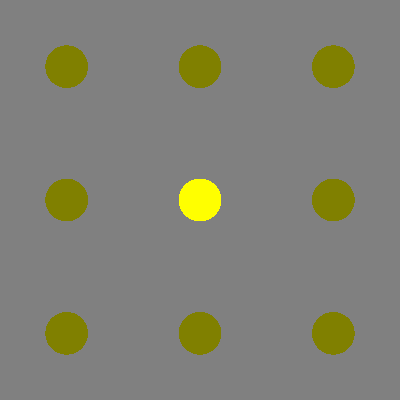

In [9]:
p = openmc.Plot();
p.width = [n_cells*pitch,n_cells*pitch];
p.origin = [0.,0.,L_channel-1.];
p.pixels = [400,400];
p.color_by = 'material';
p.colors = colors;

openmc.plot_inline(p);

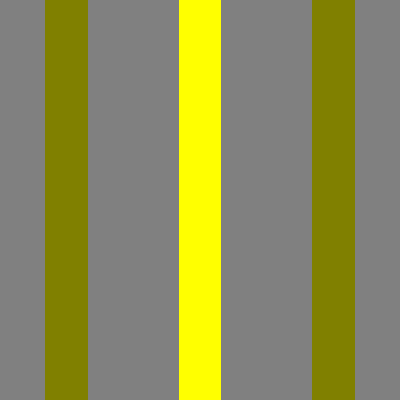

In [10]:
p2 = openmc.Plot();
p2.width = [n_cells*pitch,2*n_cells*pitch];
p2.origin = [0.,0.,L_channel/2.];
p2.pixels = [400,400];
p2.color_by = 'material';
p2.colors = colors;
p2.basis='yz';
openmc.plot_inline(p2);

Okay.  the geometry looks okay.

In [11]:
bounds = [-n_cells*pitch/2.,n_cells*pitch/2.,
          -n_cells*pitch/2.,n_cells*pitch/2.,
         0., L_channel];
uniform_dist = openmc.stats.Box(bounds[:3],bounds[3:],
                               only_fissionable=True);

settings = openmc.Settings();
settings.batches = 250;
settings.inactive = 100;
settings.particles = 10000
;

settings.source = openmc.source.Source(space=uniform_dist);

settings.export_to_xml();

In [12]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      159/1    0.90096    0.93653 +/- 0.00178
      160/1    0.92537    0.93634 +/- 0.00176
      161/1    0.90717    0.93587 +/- 0.00180
      162/1    0.92923    0.93576 +/- 0.00177
      163/1    0.96727    0.93626 +/- 0.00181
      164/1    0.95420    0.93654 +/- 0.00181
      165/1    0.94739    0.93671 +/- 0.00179
      166/1    0.92765    0.93657 +/- 0.00176
      167/1    0.93060    0.93648 +/- 0.00174
      168/1    0.91666    0.93619 +/- 0.00174
      169/1    0.93761    0.93621 +/- 0.00171
      170/1    0.95677    0.93650 +/- 0.00171
      171/1    0.92540    0.93635 +/- 0.00170
      172/1    0.93406    0.93631 +/- 0.00167
      173/1    0.94745    0.93647 +/- 0.00166
      174/1    0.93759    0.93648 +/- 0.00163
      175/1    0.92222    0.93629 +/- 0.00162
      176/1    0.92897    0.93620 +/- 0.00161
      177/1    0.96986    0.93663 +/- 0.00164
      178/1    0.92442    0.93648 +/- 0.00163
      179/1    0.93078    0.93640 +/- 0.00161
      180/1    0.94815    0.93655 

Create a function that will position the control rods at a specific location and calculate $k_{\text{eff}}$

In [13]:
def shim_rods(rod_insert_pct):
    # control rod universe
    pct_insert_cr = rod_insert_pct;
    cr_follower_len = 500; # cm, length of graphite follower

    cr_surf = openmc.ZPlane(z0=(1.-pct_insert_cr)*L_channel); #bottom surface of control rod
    crf_surf = openmc.ZPlane(z0=(1.-pct_insert_cr*L_channel)-cr_follower_len); #bottom surface of follower rod

    cr_cell = openmc.Cell();
    cr_cell.fill = b4c;
    cr_cell.region = -chan_wall & -top & +cr_surf;

    gf_cell = openmc.Cell();
    gf_cell.fill = mod;
    gf_cell.region = -chan_wall & +crf_surf & -cr_surf;

    cr_water_cell = openmc.Cell();
    cr_water_cell.fill = water;
    cr_water_cell.region = -chan_wall & +bottom & -crf_surf;

    mod_in_cr_cell = openmc.Cell();
    mod_in_cr_cell.fill = mod;
    mod_in_cr_cell.region = +chan_wall & +bottom & -top;

    cu = openmc.Universe();
    cu.add_cells([cr_cell,gf_cell,cr_water_cell,mod_in_cr_cell]);


    mod_cell = openmc.Cell();
    mod_cell.fill = mod;

    all_mod = openmc.Universe();
    all_mod.add_cell(mod_cell);


    n_cells = 3;
    pitch = 25

    left = openmc.YPlane(y0=-n_cells*pitch/2.,boundary_type='reflective');
    right = openmc.YPlane(y0=n_cells*pitch/2.,boundary_type='reflective');
    front = openmc.XPlane(x0=n_cells*pitch/2.,boundary_type='reflective');
    back = openmc.XPlane(x0=-n_cells*pitch/2.,boundary_type='reflective');

    lattice = openmc.RectLattice();
    lattice.dimension = [3,3];
    lattice.lower_left = [-n_cells*pitch/2.,-n_cells*pitch/2.];
    lattice.pitch = [pitch,pitch];

    lattice.universes = [
        [fu,fu,fu],
        [fu,cu,fu],
        [fu,fu,fu]
    ]

    lattice.outer = all_mod;

    core_cell = openmc.Cell();
    core_cell.fill = lattice;
    core_cell.region = +left & -right & -front & +back & -top & +bottom;


    root = openmc.Universe();
    root.add_cells([core_cell]);

    geometry = openmc.Geometry();
    geometry.root_universe = root;
    geometry.export_to_xml();
    
   
    

In [14]:
shim_rods(0.0);

In [15]:
pct_insert = np.linspace(0.,1.,num=11)
print(pct_insert);


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [16]:
type(pct_insert[0])

numpy.float64

In [17]:
k_array = []
pct_insert = np.linspace(0,1.,num=11)
for i in range(11):
    print(f'Shimming rods to: %4.2f percent' % (pct_insert[i]*100.));
    shim_rods(pct_insert[i]);
    openmc.run();
    sp = openmc.StatePoint('statepoint.250.h5');
    k_array.append(sp.k_combined);
    sp.__exit__();

Shimming rods to: 0.00 percent
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
       

      157/1    1.09343    1.10601 +/- 0.00197
      158/1    1.09762    1.10586 +/- 0.00194
      159/1    1.08058    1.10543 +/- 0.00196
      160/1    1.11513    1.10559 +/- 0.00193
      161/1    1.10772    1.10563 +/- 0.00190
      162/1    1.11999    1.10586 +/- 0.00188
      163/1    1.09112    1.10563 +/- 0.00187
      164/1    1.10221    1.10557 +/- 0.00184
      165/1    1.10914    1.10563 +/- 0.00181
      166/1    1.12218    1.10588 +/- 0.00180
      167/1    1.12493    1.10616 +/- 0.00180
      168/1    1.08101    1.10579 +/- 0.00181
      169/1    1.09025    1.10557 +/- 0.00180
      170/1    1.10873    1.10561 +/- 0.00177
      171/1    1.10500    1.10561 +/- 0.00175
      172/1    1.09953    1.10552 +/- 0.00172
      173/1    1.09782    1.10542 +/- 0.00170
      174/1    1.10267    1.10538 +/- 0.00168
      175/1    1.09977    1.10530 +/- 0.00166
      176/1    1.12437    1.10555 +/- 0.00166
      177/1    1.10348    1.10553 +/- 0.00163
      178/1    1.11094    1.10560 

 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neutron data temperature: 294.0 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000.0 eV for H1
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.04857
        2/1    1.06531
        3/1    1.07110
        4/1    1.08144
        5/1    1.07690
        6/1    1.09615
        7/1    1.06789
        8/1    1.08615
        9/1    1.0

      213/1    1.09455    1.10524 +/- 0.00115
      214/1    1.09020    1.10510 +/- 0.00115
      215/1    1.08979    1.10497 +/- 0.00115
      216/1    1.09484    1.10488 +/- 0.00114
      217/1    1.09561    1.10480 +/- 0.00114
      218/1    1.13575    1.10507 +/- 0.00116
      219/1    1.09775    1.10501 +/- 0.00115
      220/1    1.09799    1.10495 +/- 0.00114
      221/1    1.09432    1.10486 +/- 0.00113
      222/1    1.10729    1.10488 +/- 0.00113
      223/1    1.09823    1.10483 +/- 0.00112
      224/1    1.08671    1.10468 +/- 0.00112
      225/1    1.10528    1.10468 +/- 0.00111
      226/1    1.09907    1.10464 +/- 0.00110
      227/1    1.10906    1.10467 +/- 0.00109
      228/1    1.11886    1.10478 +/- 0.00109
      229/1    1.08218    1.10461 +/- 0.00110
      230/1    1.08464    1.10446 +/- 0.00110
      231/1    1.12587    1.10462 +/- 0.00110
      232/1    1.11728    1.10472 +/- 0.00110
      233/1    1.10647    1.10473 +/- 0.00109
      234/1    1.13255    1.10494 

       78/1    1.09899
       79/1    1.11279
       80/1    1.09960
       81/1    1.09473
       82/1    1.11653
       83/1    1.10525
       84/1    1.10199
       85/1    1.07913
       86/1    1.13502
       87/1    1.11241
       88/1    1.09353
       89/1    1.08517
       90/1    1.10134
       91/1    1.07969
       92/1    1.11119
       93/1    1.09784
       94/1    1.10703
       95/1    1.07270
       96/1    1.12772
       97/1    1.10859
       98/1    1.09080
       99/1    1.10406
      100/1    1.10419
      101/1    1.10596
      102/1    1.10889    1.10742 +/- 0.00146
      103/1    1.09876    1.10454 +/- 0.00301
      104/1    1.08501    1.09965 +/- 0.00533
      105/1    1.09400    1.09852 +/- 0.00428
      106/1    1.11552    1.10136 +/- 0.00450
      107/1    1.08932    1.09964 +/- 0.00417
      108/1    1.09908    1.09957 +/- 0.00361
      109/1    1.08073    1.09747 +/- 0.00381
      110/1    1.10674    1.09840 +/- 0.00353
      111/1    1.11139    1.09958 

 Reading O17 from /home/sblair/OMC_DATA/endfb71_hdf5/O17.h5
 Reading U234 from /home/sblair/OMC_DATA/endfb71_hdf5/U234.h5
 Reading U235 from /home/sblair/OMC_DATA/endfb71_hdf5/U235.h5
 Reading U238 from /home/sblair/OMC_DATA/endfb71_hdf5/U238.h5
 Reading U236 from /home/sblair/OMC_DATA/endfb71_hdf5/U236.h5
 Reading Zr90 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neut

      201/1    1.09183    1.09711 +/- 0.00113
      202/1    1.10522    1.09719 +/- 0.00112
      203/1    1.11316    1.09735 +/- 0.00112
      204/1    1.10826    1.09745 +/- 0.00111
      205/1    1.11265    1.09760 +/- 0.00111
      206/1    1.09248    1.09755 +/- 0.00110
      207/1    1.11214    1.09768 +/- 0.00110
      208/1    1.09469    1.09766 +/- 0.00109
      209/1    1.09528    1.09763 +/- 0.00108
      210/1    1.09056    1.09757 +/- 0.00107
      211/1    1.10608    1.09765 +/- 0.00107
      212/1    1.10487    1.09771 +/- 0.00106
      213/1    1.09115    1.09765 +/- 0.00105
      214/1    1.09677    1.09765 +/- 0.00104
      215/1    1.10441    1.09770 +/- 0.00103
      216/1    1.10126    1.09773 +/- 0.00103
      217/1    1.08484    1.09762 +/- 0.00102
      218/1    1.10297    1.09767 +/- 0.00101
      219/1    1.06965    1.09743 +/- 0.00103
      220/1    1.10931    1.09753 +/- 0.00103
      221/1    1.08737    1.09745 +/- 0.00102
      222/1    1.11854    1.09762 

       54/1    1.07950
       55/1    1.08703
       56/1    1.09099
       57/1    1.09183
       58/1    1.09305
       59/1    1.09295
       60/1    1.09094
       61/1    1.11299
       62/1    1.09549
       63/1    1.11117
       64/1    1.10622
       65/1    1.10794
       66/1    1.09393
       67/1    1.08921
       68/1    1.08574
       69/1    1.10821
       70/1    1.10664
       71/1    1.09303
       72/1    1.10256
       73/1    1.08473
       74/1    1.09281
       75/1    1.09113
       76/1    1.07731
       77/1    1.07795
       78/1    1.09064
       79/1    1.10816
       80/1    1.09123
       81/1    1.09954
       82/1    1.10076
       83/1    1.09420
       84/1    1.11043
       85/1    1.08742
       86/1    1.08642
       87/1    1.10817
       88/1    1.10122
       89/1    1.08149
       90/1    1.08745
       91/1    1.10151
       92/1    1.07363
       93/1    1.10395
       94/1    1.07164
       95/1    1.07264
       96/1    1.09855
       97/1

 Reading O17 from /home/sblair/OMC_DATA/endfb71_hdf5/O17.h5
 Reading U234 from /home/sblair/OMC_DATA/endfb71_hdf5/U234.h5
 Reading U235 from /home/sblair/OMC_DATA/endfb71_hdf5/U235.h5
 Reading U238 from /home/sblair/OMC_DATA/endfb71_hdf5/U238.h5
 Reading U236 from /home/sblair/OMC_DATA/endfb71_hdf5/U236.h5
 Reading Zr90 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neut

      201/1    1.10153    1.08606 +/- 0.00117
      202/1    1.07783    1.08598 +/- 0.00116
      203/1    1.09442    1.08606 +/- 0.00116
      204/1    1.09678    1.08617 +/- 0.00115
      205/1    1.09978    1.08630 +/- 0.00115
      206/1    1.07885    1.08623 +/- 0.00114
      207/1    1.09670    1.08633 +/- 0.00113
      208/1    1.09709    1.08643 +/- 0.00112
      209/1    1.08481    1.08641 +/- 0.00111
      210/1    1.08045    1.08636 +/- 0.00111
      211/1    1.07690    1.08627 +/- 0.00110
      212/1    1.07596    1.08618 +/- 0.00109
      213/1    1.07705    1.08610 +/- 0.00109
      214/1    1.07640    1.08601 +/- 0.00108
      215/1    1.07926    1.08595 +/- 0.00107
      216/1    1.09014    1.08599 +/- 0.00106
      217/1    1.07987    1.08594 +/- 0.00106
      218/1    1.08689    1.08595 +/- 0.00105
      219/1    1.09801    1.08605 +/- 0.00104
      220/1    1.07016    1.08591 +/- 0.00104
      221/1    1.11276    1.08614 +/- 0.00106
      222/1    1.07401    1.08604 

       54/1    1.07421
       55/1    1.07904
       56/1    1.07971
       57/1    1.05004
       58/1    1.08065
       59/1    1.06294
       60/1    1.06319
       61/1    1.05254
       62/1    1.08382
       63/1    1.06177
       64/1    1.07409
       65/1    1.08825
       66/1    1.08708
       67/1    1.06260
       68/1    1.06425
       69/1    1.09966
       70/1    1.07022
       71/1    1.05915
       72/1    1.07005
       73/1    1.05194
       74/1    1.09038
       75/1    1.06568
       76/1    1.06571
       77/1    1.07927
       78/1    1.07189
       79/1    1.06873
       80/1    1.05454
       81/1    1.05052
       82/1    1.08129
       83/1    1.09235
       84/1    1.07152
       85/1    1.07311
       86/1    1.09866
       87/1    1.07039
       88/1    1.06664
       89/1    1.07909
       90/1    1.06284
       91/1    1.05787
       92/1    1.07307
       93/1    1.06384
       94/1    1.07033
       95/1    1.07754
       96/1    1.07481
       97/1

 Reading O17 from /home/sblair/OMC_DATA/endfb71_hdf5/O17.h5
 Reading U234 from /home/sblair/OMC_DATA/endfb71_hdf5/U234.h5
 Reading U235 from /home/sblair/OMC_DATA/endfb71_hdf5/U235.h5
 Reading U238 from /home/sblair/OMC_DATA/endfb71_hdf5/U238.h5
 Reading U236 from /home/sblair/OMC_DATA/endfb71_hdf5/U236.h5
 Reading Zr90 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neut

      203/1    1.04159    1.04742 +/- 0.00114
      204/1    1.03487    1.04730 +/- 0.00114
      205/1    1.05924    1.04741 +/- 0.00113
      206/1    1.07287    1.04765 +/- 0.00115
      207/1    1.06180    1.04778 +/- 0.00114
      208/1    1.03545    1.04767 +/- 0.00114
      209/1    1.03740    1.04757 +/- 0.00113
      210/1    1.04738    1.04757 +/- 0.00112
      211/1    1.07427    1.04781 +/- 0.00114
      212/1    1.04232    1.04776 +/- 0.00113
      213/1    1.05690    1.04785 +/- 0.00112
      214/1    1.02233    1.04762 +/- 0.00113
      215/1    1.02960    1.04746 +/- 0.00113
      216/1    1.04915    1.04748 +/- 0.00112
      217/1    1.05586    1.04755 +/- 0.00112
      218/1    1.03601    1.04745 +/- 0.00111
      219/1    1.04595    1.04744 +/- 0.00110
      220/1    1.05653    1.04752 +/- 0.00110
      221/1    1.03820    1.04744 +/- 0.00109
      222/1    1.02836    1.04728 +/- 0.00109
      223/1    1.05983    1.04738 +/- 0.00109
      224/1    1.05850    1.04747 

       58/1    1.00690
       59/1    1.01446
       60/1    0.99273
       61/1    0.98344
       62/1    1.00021
       63/1    1.00706
       64/1    0.99002
       65/1    0.99657
       66/1    0.98293
       67/1    1.00875
       68/1    1.00057
       69/1    0.98210
       70/1    0.98897
       71/1    1.01250
       72/1    0.98806
       73/1    1.00033
       74/1    0.99182
       75/1    1.00824
       76/1    1.01401
       77/1    1.01306
       78/1    0.99661
       79/1    0.98403
       80/1    1.01297
       81/1    1.00535
       82/1    1.02029
       83/1    0.98682
       84/1    1.00956
       85/1    1.01080
       86/1    1.01269
       87/1    0.98387
       88/1    1.02513
       89/1    1.00221
       90/1    0.98755
       91/1    0.98978
       92/1    1.00225
       93/1    1.03364
       94/1    0.98633
       95/1    0.99227
       96/1    1.00971
       97/1    0.98055
       98/1    1.00286
       99/1    0.99631
      100/1    0.99544
      101/1

 Reading O17 from /home/sblair/OMC_DATA/endfb71_hdf5/O17.h5
 Reading U234 from /home/sblair/OMC_DATA/endfb71_hdf5/U234.h5
 Reading U235 from /home/sblair/OMC_DATA/endfb71_hdf5/U235.h5
 Reading U238 from /home/sblair/OMC_DATA/endfb71_hdf5/U238.h5
 Reading U236 from /home/sblair/OMC_DATA/endfb71_hdf5/U236.h5
 Reading Zr90 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neut

      203/1    0.92702    0.93932 +/- 0.00109
      204/1    0.93088    0.93924 +/- 0.00108
      205/1    0.93325    0.93919 +/- 0.00107
      206/1    0.96022    0.93938 +/- 0.00108
      207/1    0.93041    0.93930 +/- 0.00107
      208/1    0.92100    0.93913 +/- 0.00108
      209/1    0.94413    0.93918 +/- 0.00107
      210/1    0.93221    0.93911 +/- 0.00106
      211/1    0.93925    0.93911 +/- 0.00105
      212/1    0.92223    0.93896 +/- 0.00105
      213/1    0.94299    0.93900 +/- 0.00104
      214/1    0.92992    0.93892 +/- 0.00104
      215/1    0.94521    0.93897 +/- 0.00103
      216/1    0.93814    0.93897 +/- 0.00102
      217/1    0.92619    0.93886 +/- 0.00102
      218/1    0.93478    0.93882 +/- 0.00101
      219/1    0.92966    0.93875 +/- 0.00100
      220/1    0.94038    0.93876 +/- 0.00100
      221/1    0.92945    0.93868 +/- 0.00099
      222/1    0.91902    0.93852 +/- 0.00100
      223/1    0.95373    0.93865 +/- 0.00100
      224/1    0.93051    0.93858 

       60/1    0.93112
       61/1    0.94741
       62/1    0.93184
       63/1    0.93318
       64/1    0.92936
       65/1    0.92953
       66/1    0.92214
       67/1    0.93724
       68/1    0.94487
       69/1    0.94635
       70/1    0.94642
       71/1    0.95211
       72/1    0.94554
       73/1    0.93040
       74/1    0.95225
       75/1    0.94157
       76/1    0.92672
       77/1    0.94009
       78/1    0.93879
       79/1    0.95630
       80/1    0.94632
       81/1    0.94760
       82/1    0.93539
       83/1    0.92447
       84/1    0.95185
       85/1    0.95157
       86/1    0.93650
       87/1    0.92530
       88/1    0.93075
       89/1    0.93613
       90/1    0.92278
       91/1    0.94721
       92/1    0.93639
       93/1    0.93142
       94/1    0.92861
       95/1    0.95234
       96/1    0.93239
       97/1    0.96975
       98/1    0.93153
       99/1    0.94019
      100/1    0.95583
      101/1    0.94749
      102/1    0.93153    0.93951 

 k-effective (Collision)     = 0.93709 +/- 0.00101
 k-effective (Track-length)  = 0.93731 +/- 0.00106
 k-effective (Absorption)    = 0.93803 +/- 0.00081
 Combined k-effective        = 0.93761 +/- 0.00070
 Leakage Fraction            = 0.00643 +/- 0.00008



package the results in an array that can be plotted.

In [18]:
k_out = np.ndarray((2,11),dtype=np.float64);
for i in range(11):
    k = k_array[i];
    k_out[0,i]=k.nominal_value;
    k_out[1,i]=k.std_dev;
    

In [19]:
from matplotlib import pyplot

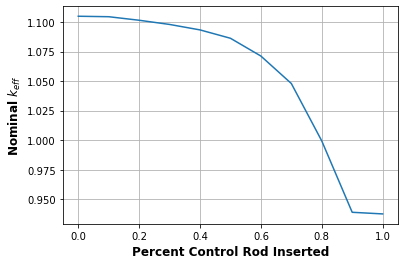

In [20]:
pyplot.plot(pct_insert,k_out[0,:]);
pyplot.grid();
pyplot.xlabel('Percent Control Rod Inserted',fontsize=12,fontweight='bold');
pyplot.ylabel('Nominal $k_{eff}$',fontsize=12,fontweight='bold');

Let's repeat this analysis, but this time without the graphite follower

In [21]:
def shim_rods_no_follower(rod_insert_pct):
    # control rod universe
    pct_insert_cr = rod_insert_pct;
    cr_follower_len = 50; # cm, length of graphite follower

    cr_surf = openmc.ZPlane(z0=(1.-pct_insert_cr)*L_channel); #bottom surface of control rod
    crf_surf = openmc.ZPlane(z0=(1.-pct_insert_cr*L_channel)-cr_follower_len); #bottom surface of follower rod

    cr_cell = openmc.Cell();
    cr_cell.fill = b4c;
    cr_cell.region = -chan_wall & -top & +cr_surf;

    gf_cell = openmc.Cell();
    gf_cell.fill = water;
    gf_cell.region = -chan_wall & +crf_surf & -cr_surf;

    cr_water_cell = openmc.Cell();
    cr_water_cell.fill = water;
    cr_water_cell.region = -chan_wall & +bottom & -crf_surf;

    mod_in_cr_cell = openmc.Cell();
    mod_in_cr_cell.fill = mod;
    mod_in_cr_cell.region = +chan_wall & +bottom & -top;

    cu = openmc.Universe();
    cu.add_cells([cr_cell,gf_cell,cr_water_cell,mod_in_cr_cell]);


    mod_cell = openmc.Cell();
    mod_cell.fill = mod;

    all_mod = openmc.Universe();
    all_mod.add_cell(mod_cell);


    n_cells = 3;
    pitch = 25

    left = openmc.YPlane(y0=-n_cells*pitch/2.,boundary_type='reflective');
    right = openmc.YPlane(y0=n_cells*pitch/2.,boundary_type='reflective');
    front = openmc.XPlane(x0=n_cells*pitch/2.,boundary_type='reflective');
    back = openmc.XPlane(x0=-n_cells*pitch/2.,boundary_type='reflective');

    lattice = openmc.RectLattice();
    lattice.dimension = [3,3];
    lattice.lower_left = [-n_cells*pitch/2.,-n_cells*pitch/2.];
    lattice.pitch = [pitch,pitch];

    lattice.universes = [
        [fu,fu,fu],
        [fu,cu,fu],
        [fu,fu,fu]
    ]

    lattice.outer = all_mod;

    core_cell = openmc.Cell();
    core_cell.fill = lattice;
    core_cell.region = +left & -right & -front & +back & -top & +bottom;


    root = openmc.Universe();
    root.add_cells([core_cell]);

    geometry = openmc.Geometry();
    geometry.root_universe = root;
    geometry.export_to_xml();
    

In [22]:
k_array_nf = []
pct_insert = np.linspace(0,1.,num=11)
for i in range(11):
    print(f'Shimming rods to: %4.2f percent' % (pct_insert[i]*100.));
    shim_rods_no_follower(pct_insert[i]);
    openmc.run();
    sp = openmc.StatePoint('statepoint.250.h5');
    k_array_nf.append(sp.k_combined);
    sp.__exit__();

Shimming rods to: 0.00 percent
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
       

      157/1    1.06353    1.06356 +/- 0.00140
      158/1    1.06871    1.06365 +/- 0.00138
      159/1    1.06745    1.06371 +/- 0.00136
      160/1    1.06098    1.06367 +/- 0.00134
      161/1    1.10126    1.06429 +/- 0.00145
      162/1    1.06465    1.06429 +/- 0.00143
      163/1    1.06436    1.06429 +/- 0.00141
      164/1    1.07450    1.06445 +/- 0.00139
      165/1    1.05494    1.06431 +/- 0.00138
      166/1    1.06459    1.06431 +/- 0.00136
      167/1    1.07541    1.06448 +/- 0.00135
      168/1    1.07936    1.06469 +/- 0.00135
      169/1    1.05949    1.06462 +/- 0.00133
      170/1    1.07847    1.06482 +/- 0.00132
      171/1    1.06684    1.06485 +/- 0.00131
      172/1    1.08979    1.06519 +/- 0.00133
      173/1    1.07580    1.06534 +/- 0.00132
      174/1    1.05725    1.06523 +/- 0.00131
      175/1    1.05237    1.06506 +/- 0.00130
      176/1    1.08354    1.06530 +/- 0.00131
      177/1    1.07495    1.06543 +/- 0.00130
      178/1    1.07698    1.06557 

 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neutron data temperature: 294.0 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000.0 eV for H1
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.01363
        2/1    1.03516
        3/1    1.04458
        4/1    1.06656
        5/1    1.05206
        6/1    1.05457
        7/1    1.04990
        8/1    1.05990
        9/1    1.0

      213/1    1.07309    1.06514 +/- 0.00113
      214/1    1.06048    1.06510 +/- 0.00112
      215/1    1.06651    1.06511 +/- 0.00111
      216/1    1.05569    1.06503 +/- 0.00111
      217/1    1.06382    1.06502 +/- 0.00110
      218/1    1.06516    1.06502 +/- 0.00109
      219/1    1.06484    1.06502 +/- 0.00108
      220/1    1.06582    1.06503 +/- 0.00107
      221/1    1.05500    1.06494 +/- 0.00107
      222/1    1.04861    1.06481 +/- 0.00106
      223/1    1.05635    1.06474 +/- 0.00106
      224/1    1.07539    1.06483 +/- 0.00105
      225/1    1.06513    1.06483 +/- 0.00104
      226/1    1.07321    1.06489 +/- 0.00104
      227/1    1.09202    1.06511 +/- 0.00105
      228/1    1.05764    1.06505 +/- 0.00105
      229/1    1.06226    1.06503 +/- 0.00104
      230/1    1.06978    1.06507 +/- 0.00103
      231/1    1.05644    1.06500 +/- 0.00102
      232/1    1.06533    1.06500 +/- 0.00102
      233/1    1.04126    1.06482 +/- 0.00102
      234/1    1.09132    1.06502 

       78/1    1.06035
       79/1    1.04486
       80/1    1.05899
       81/1    1.03399
       82/1    1.05888
       83/1    1.07511
       84/1    1.06335
       85/1    1.05338
       86/1    1.09143
       87/1    1.06159
       88/1    1.05310
       89/1    1.06771
       90/1    1.06391
       91/1    1.05016
       92/1    1.06608
       93/1    1.05049
       94/1    1.07447
       95/1    1.06357
       96/1    1.06654
       97/1    1.06796
       98/1    1.06908
       99/1    1.05780
      100/1    1.05906
      101/1    1.04146
      102/1    1.05497    1.04821 +/- 0.00676
      103/1    1.07564    1.05736 +/- 0.00994
      104/1    1.05747    1.05738 +/- 0.00703
      105/1    1.04909    1.05573 +/- 0.00569
      106/1    1.07947    1.05968 +/- 0.00610
      107/1    1.07968    1.06254 +/- 0.00590
      108/1    1.04482    1.06033 +/- 0.00557
      109/1    1.04214    1.05830 +/- 0.00531
      110/1    1.05803    1.05828 +/- 0.00475
      111/1    1.06639    1.05902 

 Reading O17 from /home/sblair/OMC_DATA/endfb71_hdf5/O17.h5
 Reading U234 from /home/sblair/OMC_DATA/endfb71_hdf5/U234.h5
 Reading U235 from /home/sblair/OMC_DATA/endfb71_hdf5/U235.h5
 Reading U238 from /home/sblair/OMC_DATA/endfb71_hdf5/U238.h5
 Reading U236 from /home/sblair/OMC_DATA/endfb71_hdf5/U236.h5
 Reading Zr90 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neut

      201/1    1.06300    1.05913 +/- 0.00127
      202/1    1.04767    1.05902 +/- 0.00126
      203/1    1.02349    1.05868 +/- 0.00129
      204/1    1.06300    1.05872 +/- 0.00128
      205/1    1.05909    1.05872 +/- 0.00127
      206/1    1.05043    1.05864 +/- 0.00126
      207/1    1.06355    1.05869 +/- 0.00125
      208/1    1.01758    1.05831 +/- 0.00129
      209/1    1.06431    1.05836 +/- 0.00128
      210/1    1.05949    1.05837 +/- 0.00127
      211/1    1.05428    1.05834 +/- 0.00126
      212/1    1.04845    1.05825 +/- 0.00125
      213/1    1.07248    1.05838 +/- 0.00125
      214/1    1.06964    1.05847 +/- 0.00124
      215/1    1.05210    1.05842 +/- 0.00123
      216/1    1.04886    1.05834 +/- 0.00122
      217/1    1.05957    1.05835 +/- 0.00121
      218/1    1.05808    1.05834 +/- 0.00120
      219/1    1.06063    1.05836 +/- 0.00119
      220/1    1.05090    1.05830 +/- 0.00118
      221/1    1.05733    1.05829 +/- 0.00117
      222/1    1.04173    1.05816 

       54/1    1.05914
       55/1    1.02698
       56/1    1.05991
       57/1    1.07167
       58/1    1.05117
       59/1    1.04863
       60/1    1.07233
       61/1    1.03980
       62/1    1.05389
       63/1    1.03487
       64/1    1.02871
       65/1    1.06436
       66/1    1.08433
       67/1    1.03773
       68/1    1.03032
       69/1    1.06889
       70/1    1.04411
       71/1    1.06773
       72/1    1.06989
       73/1    1.05418
       74/1    1.06013
       75/1    1.04428
       76/1    1.07057
       77/1    1.04268
       78/1    1.05550
       79/1    1.04567
       80/1    1.06770
       81/1    1.06580
       82/1    1.04556
       83/1    1.06719
       84/1    1.09800
       85/1    1.06727
       86/1    1.03976
       87/1    1.05079
       88/1    1.05829
       89/1    1.04442
       90/1    1.05334
       91/1    1.04110
       92/1    1.05518
       93/1    1.03684
       94/1    1.06042
       95/1    1.05581
       96/1    1.06050
       97/1

 Reading O17 from /home/sblair/OMC_DATA/endfb71_hdf5/O17.h5
 Reading U234 from /home/sblair/OMC_DATA/endfb71_hdf5/U234.h5
 Reading U235 from /home/sblair/OMC_DATA/endfb71_hdf5/U235.h5
 Reading U238 from /home/sblair/OMC_DATA/endfb71_hdf5/U238.h5
 Reading U236 from /home/sblair/OMC_DATA/endfb71_hdf5/U236.h5
 Reading Zr90 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neut

      201/1    1.02574    1.04732 +/- 0.00135
      202/1    1.04909    1.04734 +/- 0.00133
      203/1    1.04256    1.04729 +/- 0.00132
      204/1    1.01376    1.04697 +/- 0.00135
      205/1    1.04223    1.04693 +/- 0.00133
      206/1    1.04652    1.04692 +/- 0.00132
      207/1    1.07430    1.04718 +/- 0.00133
      208/1    1.04136    1.04712 +/- 0.00132
      209/1    1.03744    1.04703 +/- 0.00131
      210/1    1.04953    1.04706 +/- 0.00130
      211/1    1.04007    1.04699 +/- 0.00129
      212/1    1.02749    1.04682 +/- 0.00129
      213/1    1.06383    1.04697 +/- 0.00129
      214/1    1.05972    1.04708 +/- 0.00128
      215/1    1.03707    1.04700 +/- 0.00127
      216/1    1.06118    1.04712 +/- 0.00127
      217/1    1.06624    1.04728 +/- 0.00127
      218/1    1.05672    1.04736 +/- 0.00126
      219/1    1.05011    1.04738 +/- 0.00125
      220/1    1.05751    1.04747 +/- 0.00124
      221/1    1.03939    1.04740 +/- 0.00123
      222/1    1.04722    1.04740 

       54/1    1.02384
       55/1    1.01660
       56/1    1.05720
       57/1    1.03019
       58/1    1.04578
       59/1    1.03463
       60/1    1.02348
       61/1    1.02895
       62/1    1.03788
       63/1    1.03274
       64/1    1.04237
       65/1    1.02591
       66/1    1.03859
       67/1    1.04039
       68/1    1.02441
       69/1    1.05768
       70/1    1.03092
       71/1    1.04513
       72/1    1.03865
       73/1    1.01448
       74/1    1.03091
       75/1    1.02871
       76/1    1.05990
       77/1    1.02511
       78/1    1.02159
       79/1    1.03066
       80/1    1.02465
       81/1    1.04153
       82/1    1.04726
       83/1    1.02837
       84/1    1.01874
       85/1    1.04489
       86/1    1.04179
       87/1    1.05252
       88/1    1.04790
       89/1    1.02207
       90/1    1.01922
       91/1    1.04471
       92/1    1.02472
       93/1    1.05457
       94/1    1.04632
       95/1    1.05717
       96/1    1.02581
       97/1

 Reading O17 from /home/sblair/OMC_DATA/endfb71_hdf5/O17.h5
 Reading U234 from /home/sblair/OMC_DATA/endfb71_hdf5/U234.h5
 Reading U235 from /home/sblair/OMC_DATA/endfb71_hdf5/U235.h5
 Reading U238 from /home/sblair/OMC_DATA/endfb71_hdf5/U238.h5
 Reading U236 from /home/sblair/OMC_DATA/endfb71_hdf5/U236.h5
 Reading Zr90 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neut

      202/1    1.01688    1.01702 +/- 0.00130
      203/1    0.98682    1.01673 +/- 0.00132
      204/1    1.00103    1.01658 +/- 0.00132
      205/1    1.02187    1.01663 +/- 0.00131
      206/1    1.02250    1.01668 +/- 0.00129
      207/1    1.03464    1.01685 +/- 0.00129
      208/1    1.02015    1.01688 +/- 0.00128
      209/1    1.02267    1.01694 +/- 0.00127
      210/1    0.99661    1.01675 +/- 0.00127
      211/1    1.01078    1.01670 +/- 0.00126
      212/1    1.02493    1.01677 +/- 0.00125
      213/1    1.00371    1.01666 +/- 0.00125
      214/1    1.00163    1.01652 +/- 0.00124
      215/1    1.02444    1.01659 +/- 0.00123
      216/1    1.03480    1.01675 +/- 0.00123
      217/1    1.02318    1.01680 +/- 0.00122
      218/1    1.03379    1.01695 +/- 0.00122
      219/1    1.03016    1.01706 +/- 0.00122
      220/1    1.01247    1.01702 +/- 0.00121
      221/1    1.00960    1.01696 +/- 0.00120
      222/1    1.01205    1.01692 +/- 0.00119
      223/1    1.03292    1.01705 

       57/1    0.96800
       58/1    0.97775
       59/1    0.97003
       60/1    0.96512
       61/1    0.96710
       62/1    0.96757
       63/1    0.95483
       64/1    0.97209
       65/1    0.96550
       66/1    0.97015
       67/1    0.96942
       68/1    0.97844
       69/1    0.98034
       70/1    0.96849
       71/1    0.96610
       72/1    0.95782
       73/1    0.96490
       74/1    0.97066
       75/1    0.98839
       76/1    0.96862
       77/1    0.98400
       78/1    0.97412
       79/1    0.99665
       80/1    0.95689
       81/1    0.98476
       82/1    0.97724
       83/1    0.99560
       84/1    0.99697
       85/1    0.97074
       86/1    0.98892
       87/1    0.97700
       88/1    0.98151
       89/1    0.94932
       90/1    0.97003
       91/1    0.97999
       92/1    0.97126
       93/1    0.96782
       94/1    0.97769
       95/1    0.97182
       96/1    0.96971
       97/1    0.98397
       98/1    0.97234
       99/1    0.99505
      100/1

 Reading U235 from /home/sblair/OMC_DATA/endfb71_hdf5/U235.h5
 Reading U238 from /home/sblair/OMC_DATA/endfb71_hdf5/U238.h5
 Reading U236 from /home/sblair/OMC_DATA/endfb71_hdf5/U236.h5
 Reading Zr90 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neutron data temperature: 294.0 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transp

      205/1    0.90565    0.93500 +/- 0.00130
      206/1    0.95419    0.93518 +/- 0.00130
      207/1    0.91812    0.93502 +/- 0.00129
      208/1    0.93359    0.93501 +/- 0.00128
      209/1    0.93769    0.93503 +/- 0.00127
      210/1    0.91821    0.93488 +/- 0.00127
      211/1    0.91838    0.93473 +/- 0.00127
      212/1    0.96363    0.93499 +/- 0.00128
      213/1    0.93507    0.93499 +/- 0.00127
      214/1    0.95186    0.93514 +/- 0.00127
      215/1    0.92386    0.93504 +/- 0.00126
      216/1    0.91731    0.93489 +/- 0.00126
      217/1    0.91814    0.93474 +/- 0.00126
      218/1    0.94841    0.93486 +/- 0.00125
      219/1    0.96837    0.93514 +/- 0.00127
      220/1    0.94655    0.93524 +/- 0.00126
      221/1    0.93606    0.93524 +/- 0.00125
      222/1    0.93328    0.93523 +/- 0.00124
      223/1    0.94881    0.93534 +/- 0.00124
      224/1    0.94981    0.93546 +/- 0.00123
      225/1    0.95866    0.93564 +/- 0.00124
      226/1    0.92754    0.93558 

       63/1    0.93318
       64/1    0.92936
       65/1    0.92953
       66/1    0.92214
       67/1    0.93724
       68/1    0.94487
       69/1    0.94635
       70/1    0.94642
       71/1    0.95211
       72/1    0.94554
       73/1    0.93040
       74/1    0.95225
       75/1    0.94157
       76/1    0.92672
       77/1    0.94009
       78/1    0.93879
       79/1    0.95630
       80/1    0.94632
       81/1    0.94760
       82/1    0.93539
       83/1    0.92447
       84/1    0.95185
       85/1    0.95157
       86/1    0.93650
       87/1    0.92530
       88/1    0.93075
       89/1    0.93613
       90/1    0.92278
       91/1    0.94721
       92/1    0.93639
       93/1    0.93142
       94/1    0.92861
       95/1    0.95234
       96/1    0.93239
       97/1    0.96975
       98/1    0.93153
       99/1    0.94019
      100/1    0.95583
      101/1    0.94749
      102/1    0.93153    0.93951 +/- 0.00798
      103/1    0.94243    0.94048 +/- 0.00471
      104/1

In [23]:
k_out_nf = np.ndarray((2,11),dtype=np.float64);
for i in range(11):
    k = k_array_nf[i];
    k_out_nf[0,i]=k.nominal_value;
    k_out_nf[1,i]=k.std_dev;

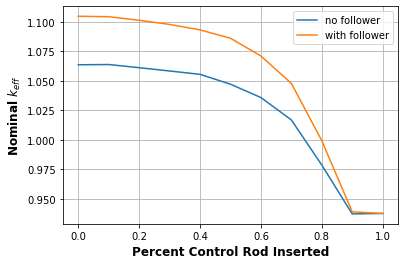

In [24]:
pyplot.plot(pct_insert,k_out_nf[0,:],label='no follower');
pyplot.plot(pct_insert,k_out[0,:],label='with follower');
pyplot.grid();
pyplot.xlabel('Percent Control Rod Inserted',fontsize=12,fontweight='bold');
pyplot.ylabel('Nominal $k_{eff}$',fontsize=12,fontweight='bold');
pyplot.legend();

Now let's re-do the test but now have the rods fully withdrawn from the start (including the graphite follower)

In [25]:
k_array_3 = []
pct_insert_2 = np.linspace(-0.15,1.,num=13)
for i in range(13):
    print(f'Shimming rods to: %4.2f percent' % (pct_insert_2[i]*100.));
    shim_rods(pct_insert_2[i]);
    openmc.run();
    sp = openmc.StatePoint('statepoint.250.h5');
    k_array_3.append(sp.k_combined);
    sp.__exit__();

Shimming rods to: -15.00 percent
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
     

      157/1    1.09343    1.10601 +/- 0.00197
      158/1    1.09762    1.10586 +/- 0.00194
      159/1    1.08058    1.10543 +/- 0.00196
      160/1    1.11513    1.10559 +/- 0.00193
      161/1    1.10772    1.10563 +/- 0.00190
      162/1    1.11999    1.10586 +/- 0.00188
      163/1    1.09112    1.10563 +/- 0.00187
      164/1    1.10221    1.10557 +/- 0.00184
      165/1    1.10914    1.10563 +/- 0.00181
      166/1    1.12218    1.10588 +/- 0.00180
      167/1    1.12493    1.10616 +/- 0.00180
      168/1    1.08101    1.10579 +/- 0.00181
      169/1    1.09025    1.10557 +/- 0.00180
      170/1    1.10873    1.10561 +/- 0.00177
      171/1    1.10500    1.10561 +/- 0.00175
      172/1    1.09953    1.10552 +/- 0.00172
      173/1    1.09782    1.10542 +/- 0.00170
      174/1    1.10267    1.10538 +/- 0.00168
      175/1    1.09977    1.10530 +/- 0.00166
      176/1    1.12437    1.10555 +/- 0.00166
      177/1    1.10348    1.10553 +/- 0.00163
      178/1    1.11094    1.10560 

 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neutron data temperature: 294.0 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000.0 eV for H1
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.06227
        2/1    1.10143
        3/1    1.08708
        4/1    1.09370
        5/1    1.08185
        6/1    1.09147
        7/1    1.11170
        8/1    1.10567
        9/1    1.0

      213/1    1.11100    1.10570 +/- 0.00126
      214/1    1.11810    1.10580 +/- 0.00126
      215/1    1.10739    1.10582 +/- 0.00125
      216/1    1.10621    1.10582 +/- 0.00124
      217/1    1.11296    1.10588 +/- 0.00123
      218/1    1.11848    1.10599 +/- 0.00122
      219/1    1.11264    1.10605 +/- 0.00121
      220/1    1.10016    1.10600 +/- 0.00120
      221/1    1.08734    1.10584 +/- 0.00120
      222/1    1.12777    1.10602 +/- 0.00121
      223/1    1.12100    1.10614 +/- 0.00120
      224/1    1.09716    1.10607 +/- 0.00120
      225/1    1.09732    1.10600 +/- 0.00119
      226/1    1.11458    1.10607 +/- 0.00118
      227/1    1.10858    1.10609 +/- 0.00117
      228/1    1.10777    1.10610 +/- 0.00116
      229/1    1.10893    1.10612 +/- 0.00115
      230/1    1.10078    1.10608 +/- 0.00115
      231/1    1.10724    1.10609 +/- 0.00114
      232/1    1.10208    1.10606 +/- 0.00113
      233/1    1.10378    1.10604 +/- 0.00112
      234/1    1.10971    1.10607 

       78/1    1.10552
       79/1    1.09436
       80/1    1.12933
       81/1    1.12019
       82/1    1.08800
       83/1    1.08981
       84/1    1.11824
       85/1    1.09783
       86/1    1.10727
       87/1    1.11569
       88/1    1.09289
       89/1    1.11546
       90/1    1.09426
       91/1    1.09522
       92/1    1.10228
       93/1    1.11198
       94/1    1.09835
       95/1    1.12823
       96/1    1.11420
       97/1    1.09517
       98/1    1.07430
       99/1    1.11199
      100/1    1.08636
      101/1    1.11816
      102/1    1.08263    1.10040 +/- 0.01776
      103/1    1.11964    1.10681 +/- 0.01210
      104/1    1.12227    1.11067 +/- 0.00939
      105/1    1.10070    1.10868 +/- 0.00754
      106/1    1.10107    1.10741 +/- 0.00628
      107/1    1.10210    1.10665 +/- 0.00537
      108/1    1.09876    1.10566 +/- 0.00475
      109/1    1.09843    1.10486 +/- 0.00427
      110/1    1.09811    1.10419 +/- 0.00387
      111/1    1.11297    1.10498 

 Reading O17 from /home/sblair/OMC_DATA/endfb71_hdf5/O17.h5
 Reading U234 from /home/sblair/OMC_DATA/endfb71_hdf5/U234.h5
 Reading U235 from /home/sblair/OMC_DATA/endfb71_hdf5/U235.h5
 Reading U238 from /home/sblair/OMC_DATA/endfb71_hdf5/U238.h5
 Reading U236 from /home/sblair/OMC_DATA/endfb71_hdf5/U236.h5
 Reading Zr90 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neut

      201/1    1.09387    1.10409 +/- 0.00135
      202/1    1.11282    1.10418 +/- 0.00134
      203/1    1.10406    1.10418 +/- 0.00133
      204/1    1.10126    1.10415 +/- 0.00131
      205/1    1.09670    1.10408 +/- 0.00130
      206/1    1.08812    1.10393 +/- 0.00130
      207/1    1.11316    1.10401 +/- 0.00129
      208/1    1.09156    1.10390 +/- 0.00128
      209/1    1.10225    1.10388 +/- 0.00127
      210/1    1.11919    1.10402 +/- 0.00127
      211/1    1.11339    1.10411 +/- 0.00126
      212/1    1.12140    1.10426 +/- 0.00126
      213/1    1.07963    1.10404 +/- 0.00127
      214/1    1.10794    1.10408 +/- 0.00125
      215/1    1.09554    1.10400 +/- 0.00125
      216/1    1.11173    1.10407 +/- 0.00124
      217/1    1.10994    1.10412 +/- 0.00123
      218/1    1.12065    1.10426 +/- 0.00122
      219/1    1.07961    1.10405 +/- 0.00123
      220/1    1.12301    1.10421 +/- 0.00123
      221/1    1.08505    1.10405 +/- 0.00123
      222/1    1.09142    1.10395 

       54/1    1.11281
       55/1    1.08599
       56/1    1.10112
       57/1    1.11407
       58/1    1.08737
       59/1    1.10538
       60/1    1.10404
       61/1    1.10286
       62/1    1.12086
       63/1    1.10813
       64/1    1.08773
       65/1    1.10332
       66/1    1.07958
       67/1    1.09472
       68/1    1.10808
       69/1    1.07828
       70/1    1.10525
       71/1    1.09438
       72/1    1.09109
       73/1    1.09585
       74/1    1.11751
       75/1    1.09784
       76/1    1.09471
       77/1    1.09267
       78/1    1.11136
       79/1    1.07892
       80/1    1.12135
       81/1    1.09414
       82/1    1.08957
       83/1    1.11012
       84/1    1.09619
       85/1    1.10550
       86/1    1.10532
       87/1    1.11336
       88/1    1.11906
       89/1    1.09038
       90/1    1.10938
       91/1    1.08964
       92/1    1.06126
       93/1    1.09381
       94/1    1.08015
       95/1    1.08534
       96/1    1.08887
       97/1

 Reading O17 from /home/sblair/OMC_DATA/endfb71_hdf5/O17.h5
 Reading U234 from /home/sblair/OMC_DATA/endfb71_hdf5/U234.h5
 Reading U235 from /home/sblair/OMC_DATA/endfb71_hdf5/U235.h5
 Reading U238 from /home/sblair/OMC_DATA/endfb71_hdf5/U238.h5
 Reading U236 from /home/sblair/OMC_DATA/endfb71_hdf5/U236.h5
 Reading Zr90 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neut

      201/1    1.10603    1.09820 +/- 0.00145
      202/1    1.10808    1.09830 +/- 0.00144
      203/1    1.09483    1.09827 +/- 0.00143
      204/1    1.08510    1.09814 +/- 0.00142
      205/1    1.08358    1.09800 +/- 0.00141
      206/1    1.10080    1.09803 +/- 0.00140
      207/1    1.08487    1.09790 +/- 0.00139
      208/1    1.09768    1.09790 +/- 0.00138
      209/1    1.10451    1.09796 +/- 0.00137
      210/1    1.12726    1.09823 +/- 0.00138
      211/1    1.08488    1.09811 +/- 0.00137
      212/1    1.09308    1.09806 +/- 0.00136
      213/1    1.07471    1.09786 +/- 0.00136
      214/1    1.11179    1.09798 +/- 0.00136
      215/1    1.11563    1.09813 +/- 0.00135
      216/1    1.10688    1.09821 +/- 0.00134
      217/1    1.09683    1.09820 +/- 0.00133
      218/1    1.10375    1.09824 +/- 0.00132
      219/1    1.09160    1.09819 +/- 0.00131
      220/1    1.09417    1.09815 +/- 0.00130
      221/1    1.09837    1.09816 +/- 0.00129
      222/1    1.10433    1.09821 

       54/1    1.09190
       55/1    1.07506
       56/1    1.07319
       57/1    1.12234
       58/1    1.10505
       59/1    1.09832
       60/1    1.08669
       61/1    1.09836
       62/1    1.08607
       63/1    1.08273
       64/1    1.08855
       65/1    1.06584
       66/1    1.07311
       67/1    1.10687
       68/1    1.07794
       69/1    1.11707
       70/1    1.10913
       71/1    1.07805
       72/1    1.07677
       73/1    1.09236
       74/1    1.11516
       75/1    1.10148
       76/1    1.09539
       77/1    1.07562
       78/1    1.11067
       79/1    1.09295
       80/1    1.08440
       81/1    1.07692
       82/1    1.10024
       83/1    1.08747
       84/1    1.07381
       85/1    1.09267
       86/1    1.07813
       87/1    1.10579
       88/1    1.09396
       89/1    1.08121
       90/1    1.09791
       91/1    1.09941
       92/1    1.10525
       93/1    1.11646
       94/1    1.12037
       95/1    1.10428
       96/1    1.10323
       97/1

 Reading O17 from /home/sblair/OMC_DATA/endfb71_hdf5/O17.h5
 Reading U234 from /home/sblair/OMC_DATA/endfb71_hdf5/U234.h5
 Reading U235 from /home/sblair/OMC_DATA/endfb71_hdf5/U235.h5
 Reading U238 from /home/sblair/OMC_DATA/endfb71_hdf5/U238.h5
 Reading U236 from /home/sblair/OMC_DATA/endfb71_hdf5/U236.h5
 Reading Zr90 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neut

      203/1    1.08041    1.08348 +/- 0.00137
      204/1    1.08270    1.08347 +/- 0.00136
      205/1    1.08737    1.08351 +/- 0.00135
      206/1    1.07539    1.08343 +/- 0.00134
      207/1    1.08167    1.08341 +/- 0.00133
      208/1    1.06908    1.08328 +/- 0.00132
      209/1    1.07736    1.08323 +/- 0.00131
      210/1    1.05753    1.08299 +/- 0.00132
      211/1    1.09671    1.08312 +/- 0.00131
      212/1    1.09209    1.08320 +/- 0.00130
      213/1    1.08727    1.08323 +/- 0.00129
      214/1    1.07866    1.08319 +/- 0.00128
      215/1    1.09425    1.08329 +/- 0.00127
      216/1    1.10628    1.08349 +/- 0.00128
      217/1    1.09622    1.08360 +/- 0.00127
      218/1    1.10722    1.08380 +/- 0.00128
      219/1    1.09024    1.08385 +/- 0.00127
      220/1    1.06023    1.08365 +/- 0.00127
      221/1    1.09975    1.08379 +/- 0.00127
      222/1    1.08810    1.08382 +/- 0.00126
      223/1    1.08580    1.08384 +/- 0.00125
      224/1    1.06771    1.08371 

       58/1    1.06658
       59/1    1.06984
       60/1    1.07625
       61/1    1.08556
       62/1    1.07692
       63/1    1.08139
       64/1    1.05710
       65/1    1.08330
       66/1    1.06346
       67/1    1.06701
       68/1    1.06168
       69/1    1.08638
       70/1    1.07526
       71/1    1.05799
       72/1    1.05827
       73/1    1.08661
       74/1    1.06683
       75/1    1.06623
       76/1    1.09001
       77/1    1.08706
       78/1    1.07058
       79/1    1.07510
       80/1    1.04264
       81/1    1.07309
       82/1    1.07331
       83/1    1.06631
       84/1    1.08226
       85/1    1.08294
       86/1    1.06913
       87/1    1.08587
       88/1    1.07677
       89/1    1.06996
       90/1    1.05172
       91/1    1.08709
       92/1    1.07173
       93/1    1.06773
       94/1    1.06347
       95/1    1.04658
       96/1    1.05378
       97/1    1.08778
       98/1    1.08195
       99/1    1.06564
      100/1    1.05904
      101/1

 Reading O17 from /home/sblair/OMC_DATA/endfb71_hdf5/O17.h5
 Reading U234 from /home/sblair/OMC_DATA/endfb71_hdf5/U234.h5
 Reading U235 from /home/sblair/OMC_DATA/endfb71_hdf5/U235.h5
 Reading U238 from /home/sblair/OMC_DATA/endfb71_hdf5/U238.h5
 Reading U236 from /home/sblair/OMC_DATA/endfb71_hdf5/U236.h5
 Reading Zr90 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neut

      202/1    1.04110    1.04441 +/- 0.00135
      203/1    1.02061    1.04418 +/- 0.00136
      204/1    1.04194    1.04416 +/- 0.00134
      205/1    1.06123    1.04432 +/- 0.00134
      206/1    1.04419    1.04432 +/- 0.00133
      207/1    1.05395    1.04441 +/- 0.00132
      208/1    1.02886    1.04427 +/- 0.00131
      209/1    1.03572    1.04419 +/- 0.00130
      210/1    1.04215    1.04417 +/- 0.00129
      211/1    1.04092    1.04414 +/- 0.00128
      212/1    1.06950    1.04437 +/- 0.00129
      213/1    1.04849    1.04440 +/- 0.00128
      214/1    1.04316    1.04439 +/- 0.00127
      215/1    1.06160    1.04454 +/- 0.00126
      216/1    1.04073    1.04451 +/- 0.00125
      217/1    1.05557    1.04460 +/- 0.00125
      218/1    1.06226    1.04475 +/- 0.00125
      219/1    1.03793    1.04470 +/- 0.00124
      220/1    1.04933    1.04473 +/- 0.00123
      221/1    1.05403    1.04481 +/- 0.00122
      222/1    1.04117    1.04478 +/- 0.00121
      223/1    1.05772    1.04489 

       59/1    0.98679
       60/1    0.99837
       61/1    0.99847
       62/1    1.01320
       63/1    0.98766
       64/1    0.99723
       65/1    1.01371
       66/1    0.96718
       67/1    1.00015
       68/1    0.98741
       69/1    1.00149
       70/1    0.98833
       71/1    0.99488
       72/1    0.99874
       73/1    0.98947
       74/1    0.97007
       75/1    0.99684
       76/1    0.99342
       77/1    0.99561
       78/1    0.97977
       79/1    0.99821
       80/1    0.98679
       81/1    0.99350
       82/1    0.99230
       83/1    0.99715
       84/1    1.00226
       85/1    1.01291
       86/1    1.00818
       87/1    1.00759
       88/1    0.99698
       89/1    0.95858
       90/1    0.99804
       91/1    0.98110
       92/1    0.98501
       93/1    0.99557
       94/1    0.99174
       95/1    0.98422
       96/1    1.00933
       97/1    0.97380
       98/1    0.99668
       99/1    0.98879
      100/1    0.97746
      101/1    0.99243
      102/1

 Reading U235 from /home/sblair/OMC_DATA/endfb71_hdf5/U235.h5
 Reading U238 from /home/sblair/OMC_DATA/endfb71_hdf5/U238.h5
 Reading U236 from /home/sblair/OMC_DATA/endfb71_hdf5/U236.h5
 Reading Zr90 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neutron data temperature: 294.0 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transp

      204/1    0.93574    0.93864 +/- 0.00120
      205/1    0.93333    0.93859 +/- 0.00119
      206/1    0.93645    0.93857 +/- 0.00118
      207/1    0.93089    0.93850 +/- 0.00117
      208/1    0.93285    0.93845 +/- 0.00116
      209/1    0.93712    0.93844 +/- 0.00115
      210/1    0.91336    0.93821 +/- 0.00116
      211/1    0.94376    0.93826 +/- 0.00115
      212/1    0.91954    0.93809 +/- 0.00115
      213/1    0.93314    0.93805 +/- 0.00114
      214/1    0.95513    0.93820 +/- 0.00114
      215/1    0.93970    0.93821 +/- 0.00113
      216/1    0.93694    0.93820 +/- 0.00112
      217/1    0.93118    0.93814 +/- 0.00112
      218/1    0.94602    0.93821 +/- 0.00111
      219/1    0.93504    0.93818 +/- 0.00110
      220/1    0.95629    0.93833 +/- 0.00110
      221/1    0.95513    0.93847 +/- 0.00110
      222/1    0.93436    0.93844 +/- 0.00109
      223/1    0.94059    0.93845 +/- 0.00108
      224/1    0.93424    0.93842 +/- 0.00107
      225/1    0.93592    0.93840 

       61/1    0.94741
       62/1    0.93184
       63/1    0.93318
       64/1    0.92936
       65/1    0.92953
       66/1    0.92214
       67/1    0.93724
       68/1    0.94487
       69/1    0.94635
       70/1    0.94642
       71/1    0.95211
       72/1    0.94554
       73/1    0.93040
       74/1    0.95225
       75/1    0.94157
       76/1    0.92672
       77/1    0.94009
       78/1    0.93879
       79/1    0.95630
       80/1    0.94632
       81/1    0.94760
       82/1    0.93539
       83/1    0.92447
       84/1    0.95185
       85/1    0.95157
       86/1    0.93650
       87/1    0.92530
       88/1    0.93075
       89/1    0.93613
       90/1    0.92278
       91/1    0.94721
       92/1    0.93639
       93/1    0.93142
       94/1    0.92861
       95/1    0.95234
       96/1    0.93239
       97/1    0.96975
       98/1    0.93153
       99/1    0.94019
      100/1    0.95583
      101/1    0.94749
      102/1    0.93153    0.93951 +/- 0.00798
      103/1

In [26]:
k_out_plus = np.ndarray((2,13),dtype=np.float64);
for i in range(13):
    k = k_array_3[i];
    k_out_plus[0,i]=k.nominal_value;
    k_out_plus[1,i]=k.std_dev;

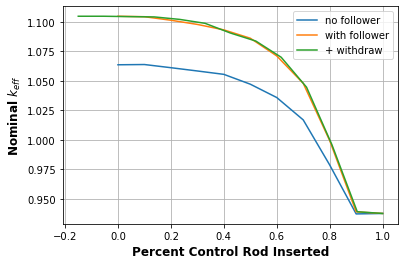

In [27]:
pyplot.plot(pct_insert,k_out_nf[0,:],label='no follower');
pyplot.plot(pct_insert,k_out[0,:],label='with follower');
pyplot.plot(pct_insert_2,k_out_plus[0,:],label='+ withdraw');
pyplot.grid();
pyplot.xlabel('Percent Control Rod Inserted',fontsize=12,fontweight='bold');
pyplot.ylabel('Nominal $k_{eff}$',fontsize=12,fontweight='bold');
pyplot.legend();

The above results should be re-done with a longer control rod follower.

In [28]:
def shim_rods_lf(rod_insert_pct):
    # control rod universe
    pct_insert_cr = rod_insert_pct;
    cr_follower_len = 700; # cm, length of graphite follower

    cr_surf = openmc.ZPlane(z0=(1.-pct_insert_cr)*L_channel); #bottom surface of control rod
    crf_surf = openmc.ZPlane(z0=(1.-pct_insert_cr*L_channel)-cr_follower_len); #bottom surface of follower rod

    cr_cell = openmc.Cell();
    cr_cell.fill = b4c;
    cr_cell.region = -chan_wall & -top & +cr_surf;

    gf_cell = openmc.Cell();
    gf_cell.fill = mod;
    gf_cell.region = -chan_wall & +crf_surf & -cr_surf;

    cr_water_cell = openmc.Cell();
    cr_water_cell.fill = water;
    cr_water_cell.region = -chan_wall & +bottom & -crf_surf;

    mod_in_cr_cell = openmc.Cell();
    mod_in_cr_cell.fill = mod;
    mod_in_cr_cell.region = +chan_wall & +bottom & -top;

    cu = openmc.Universe();
    cu.add_cells([cr_cell,gf_cell,cr_water_cell,mod_in_cr_cell]);


    mod_cell = openmc.Cell();
    mod_cell.fill = mod;

    all_mod = openmc.Universe();
    all_mod.add_cell(mod_cell);


    n_cells = 3;
    pitch = 25

    left = openmc.YPlane(y0=-n_cells*pitch/2.,boundary_type='reflective');
    right = openmc.YPlane(y0=n_cells*pitch/2.,boundary_type='reflective');
    front = openmc.XPlane(x0=n_cells*pitch/2.,boundary_type='reflective');
    back = openmc.XPlane(x0=-n_cells*pitch/2.,boundary_type='reflective');

    lattice = openmc.RectLattice();
    lattice.dimension = [3,3];
    lattice.lower_left = [-n_cells*pitch/2.,-n_cells*pitch/2.];
    lattice.pitch = [pitch,pitch];

    lattice.universes = [
        [fu,fu,fu],
        [fu,cu,fu],
        [fu,fu,fu]
    ]

    lattice.outer = all_mod;

    core_cell = openmc.Cell();
    core_cell.fill = lattice;
    core_cell.region = +left & -right & -front & +back & -top & +bottom;


    root = openmc.Universe();
    root.add_cells([core_cell]);

    geometry = openmc.Geometry();
    geometry.root_universe = root;
    geometry.export_to_xml();
    
   

In [29]:
k_array_4 = []
pct_insert_2 = np.linspace(-0.15,1.,num=13)
for i in range(13):
    print(f'Shimming rods to: %4.2f percent' % (pct_insert_2[i]*100.));
    shim_rods_lf(pct_insert_2[i]);
    openmc.run();
    sp = openmc.StatePoint('statepoint.250.h5');
    k_array_4.append(sp.k_combined);
    sp.__exit__();

Shimming rods to: -15.00 percent
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
     

      157/1    1.09343    1.10601 +/- 0.00197
      158/1    1.09762    1.10586 +/- 0.00194
      159/1    1.08058    1.10543 +/- 0.00196
      160/1    1.11513    1.10559 +/- 0.00193
      161/1    1.10772    1.10563 +/- 0.00190
      162/1    1.11999    1.10586 +/- 0.00188
      163/1    1.09112    1.10563 +/- 0.00187
      164/1    1.10221    1.10557 +/- 0.00184
      165/1    1.10914    1.10563 +/- 0.00181
      166/1    1.12218    1.10588 +/- 0.00180
      167/1    1.12493    1.10616 +/- 0.00180
      168/1    1.08101    1.10579 +/- 0.00181
      169/1    1.09025    1.10557 +/- 0.00180
      170/1    1.10873    1.10561 +/- 0.00177
      171/1    1.10500    1.10561 +/- 0.00175
      172/1    1.09953    1.10552 +/- 0.00172
      173/1    1.09782    1.10542 +/- 0.00170
      174/1    1.10267    1.10538 +/- 0.00168
      175/1    1.09977    1.10530 +/- 0.00166
      176/1    1.12437    1.10555 +/- 0.00166
      177/1    1.10348    1.10553 +/- 0.00163
      178/1    1.11094    1.10560 

 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neutron data temperature: 294.0 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000.0 eV for H1
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.06227
        2/1    1.10143
        3/1    1.08708
        4/1    1.09370
        5/1    1.08185
        6/1    1.09147
        7/1    1.11170
        8/1    1.10567
        9/1    1.0

      213/1    1.11100    1.10570 +/- 0.00126
      214/1    1.11810    1.10580 +/- 0.00126
      215/1    1.10739    1.10582 +/- 0.00125
      216/1    1.10621    1.10582 +/- 0.00124
      217/1    1.11296    1.10588 +/- 0.00123
      218/1    1.11848    1.10599 +/- 0.00122
      219/1    1.11264    1.10605 +/- 0.00121
      220/1    1.10016    1.10600 +/- 0.00120
      221/1    1.08734    1.10584 +/- 0.00120
      222/1    1.12777    1.10602 +/- 0.00121
      223/1    1.12100    1.10614 +/- 0.00120
      224/1    1.09716    1.10607 +/- 0.00120
      225/1    1.09732    1.10600 +/- 0.00119
      226/1    1.11458    1.10607 +/- 0.00118
      227/1    1.10858    1.10609 +/- 0.00117
      228/1    1.10777    1.10610 +/- 0.00116
      229/1    1.10893    1.10612 +/- 0.00115
      230/1    1.10078    1.10608 +/- 0.00115
      231/1    1.10724    1.10609 +/- 0.00114
      232/1    1.10208    1.10606 +/- 0.00113
      233/1    1.10378    1.10604 +/- 0.00112
      234/1    1.10971    1.10607 

       78/1    1.10552
       79/1    1.09436
       80/1    1.12933
       81/1    1.12019
       82/1    1.08800
       83/1    1.08981
       84/1    1.11824
       85/1    1.09783
       86/1    1.10727
       87/1    1.11569
       88/1    1.09289
       89/1    1.11546
       90/1    1.09426
       91/1    1.09522
       92/1    1.10228
       93/1    1.11198
       94/1    1.09835
       95/1    1.12823
       96/1    1.11420
       97/1    1.09517
       98/1    1.07430
       99/1    1.11199
      100/1    1.08636
      101/1    1.11816
      102/1    1.08263    1.10040 +/- 0.01776
      103/1    1.11964    1.10681 +/- 0.01210
      104/1    1.12227    1.11067 +/- 0.00939
      105/1    1.10070    1.10868 +/- 0.00754
      106/1    1.10107    1.10741 +/- 0.00628
      107/1    1.10210    1.10665 +/- 0.00537
      108/1    1.09876    1.10566 +/- 0.00475
      109/1    1.09843    1.10486 +/- 0.00427
      110/1    1.09811    1.10419 +/- 0.00387
      111/1    1.11297    1.10498 

 Reading O17 from /home/sblair/OMC_DATA/endfb71_hdf5/O17.h5
 Reading U234 from /home/sblair/OMC_DATA/endfb71_hdf5/U234.h5
 Reading U235 from /home/sblair/OMC_DATA/endfb71_hdf5/U235.h5
 Reading U238 from /home/sblair/OMC_DATA/endfb71_hdf5/U238.h5
 Reading U236 from /home/sblair/OMC_DATA/endfb71_hdf5/U236.h5
 Reading Zr90 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neut

      201/1    1.09387    1.10409 +/- 0.00135
      202/1    1.11282    1.10418 +/- 0.00134
      203/1    1.10406    1.10418 +/- 0.00133
      204/1    1.10126    1.10415 +/- 0.00131
      205/1    1.09670    1.10408 +/- 0.00130
      206/1    1.08812    1.10393 +/- 0.00130
      207/1    1.11316    1.10401 +/- 0.00129
      208/1    1.09156    1.10390 +/- 0.00128
      209/1    1.10225    1.10388 +/- 0.00127
      210/1    1.11919    1.10402 +/- 0.00127
      211/1    1.11339    1.10411 +/- 0.00126
      212/1    1.12140    1.10426 +/- 0.00126
      213/1    1.07963    1.10404 +/- 0.00127
      214/1    1.10794    1.10408 +/- 0.00125
      215/1    1.09554    1.10400 +/- 0.00125
      216/1    1.11173    1.10407 +/- 0.00124
      217/1    1.10994    1.10412 +/- 0.00123
      218/1    1.12065    1.10426 +/- 0.00122
      219/1    1.07961    1.10405 +/- 0.00123
      220/1    1.12301    1.10421 +/- 0.00123
      221/1    1.08505    1.10405 +/- 0.00123
      222/1    1.09142    1.10395 

       54/1    1.11281
       55/1    1.08599
       56/1    1.10112
       57/1    1.11407
       58/1    1.08737
       59/1    1.10538
       60/1    1.10404
       61/1    1.10286
       62/1    1.12086
       63/1    1.10813
       64/1    1.08773
       65/1    1.10332
       66/1    1.07958
       67/1    1.09472
       68/1    1.10808
       69/1    1.07828
       70/1    1.10525
       71/1    1.09438
       72/1    1.09109
       73/1    1.09585
       74/1    1.11751
       75/1    1.09784
       76/1    1.09471
       77/1    1.09267
       78/1    1.11136
       79/1    1.07892
       80/1    1.12135
       81/1    1.09414
       82/1    1.08957
       83/1    1.11012
       84/1    1.09619
       85/1    1.10550
       86/1    1.10532
       87/1    1.11336
       88/1    1.11906
       89/1    1.09038
       90/1    1.10938
       91/1    1.08964
       92/1    1.06126
       93/1    1.09381
       94/1    1.08015
       95/1    1.08534
       96/1    1.08887
       97/1

 Reading O17 from /home/sblair/OMC_DATA/endfb71_hdf5/O17.h5
 Reading U234 from /home/sblair/OMC_DATA/endfb71_hdf5/U234.h5
 Reading U235 from /home/sblair/OMC_DATA/endfb71_hdf5/U235.h5
 Reading U238 from /home/sblair/OMC_DATA/endfb71_hdf5/U238.h5
 Reading U236 from /home/sblair/OMC_DATA/endfb71_hdf5/U236.h5
 Reading Zr90 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neut

      201/1    1.10603    1.09820 +/- 0.00145
      202/1    1.10808    1.09830 +/- 0.00144
      203/1    1.09483    1.09827 +/- 0.00143
      204/1    1.08510    1.09814 +/- 0.00142
      205/1    1.08358    1.09800 +/- 0.00141
      206/1    1.10080    1.09803 +/- 0.00140
      207/1    1.08487    1.09790 +/- 0.00139
      208/1    1.09768    1.09790 +/- 0.00138
      209/1    1.10451    1.09796 +/- 0.00137
      210/1    1.12726    1.09823 +/- 0.00138
      211/1    1.08488    1.09811 +/- 0.00137
      212/1    1.09308    1.09806 +/- 0.00136
      213/1    1.07471    1.09786 +/- 0.00136
      214/1    1.11179    1.09798 +/- 0.00136
      215/1    1.11563    1.09813 +/- 0.00135
      216/1    1.10688    1.09821 +/- 0.00134
      217/1    1.09683    1.09820 +/- 0.00133
      218/1    1.10375    1.09824 +/- 0.00132
      219/1    1.09160    1.09819 +/- 0.00131
      220/1    1.09417    1.09815 +/- 0.00130
      221/1    1.09837    1.09816 +/- 0.00129
      222/1    1.10433    1.09821 

       54/1    1.09190
       55/1    1.07506
       56/1    1.07319
       57/1    1.12234
       58/1    1.10505
       59/1    1.09832
       60/1    1.08669
       61/1    1.09836
       62/1    1.08607
       63/1    1.08273
       64/1    1.08855
       65/1    1.06584
       66/1    1.07311
       67/1    1.10687
       68/1    1.07794
       69/1    1.11707
       70/1    1.10913
       71/1    1.07805
       72/1    1.07677
       73/1    1.09236
       74/1    1.11516
       75/1    1.10148
       76/1    1.09539
       77/1    1.07562
       78/1    1.11067
       79/1    1.09295
       80/1    1.08440
       81/1    1.07692
       82/1    1.10024
       83/1    1.08747
       84/1    1.07381
       85/1    1.09267
       86/1    1.07813
       87/1    1.10579
       88/1    1.09396
       89/1    1.08121
       90/1    1.09791
       91/1    1.09941
       92/1    1.10525
       93/1    1.11646
       94/1    1.12037
       95/1    1.10428
       96/1    1.10323
       97/1

 Reading O17 from /home/sblair/OMC_DATA/endfb71_hdf5/O17.h5
 Reading U234 from /home/sblair/OMC_DATA/endfb71_hdf5/U234.h5
 Reading U235 from /home/sblair/OMC_DATA/endfb71_hdf5/U235.h5
 Reading U238 from /home/sblair/OMC_DATA/endfb71_hdf5/U238.h5
 Reading U236 from /home/sblair/OMC_DATA/endfb71_hdf5/U236.h5
 Reading Zr90 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neut

      201/1    1.08147    1.08345 +/- 0.00140
      202/1    1.08983    1.08351 +/- 0.00139
      203/1    1.08041    1.08348 +/- 0.00137
      204/1    1.08270    1.08347 +/- 0.00136
      205/1    1.08737    1.08351 +/- 0.00135
      206/1    1.07539    1.08343 +/- 0.00134
      207/1    1.08167    1.08341 +/- 0.00133
      208/1    1.06908    1.08328 +/- 0.00132
      209/1    1.07736    1.08323 +/- 0.00131
      210/1    1.05753    1.08299 +/- 0.00132
      211/1    1.09671    1.08312 +/- 0.00131
      212/1    1.09209    1.08320 +/- 0.00130
      213/1    1.08727    1.08323 +/- 0.00129
      214/1    1.07866    1.08319 +/- 0.00128
      215/1    1.09425    1.08329 +/- 0.00127
      216/1    1.10628    1.08349 +/- 0.00128
      217/1    1.09622    1.08360 +/- 0.00127
      218/1    1.10722    1.08380 +/- 0.00128
      219/1    1.09024    1.08385 +/- 0.00127
      220/1    1.06023    1.08365 +/- 0.00127
      221/1    1.09975    1.08379 +/- 0.00127
      222/1    1.08810    1.08382 

       54/1    1.06355
       55/1    1.05368
       56/1    1.06979
       57/1    1.06396
       58/1    1.06658
       59/1    1.06984
       60/1    1.07625
       61/1    1.08556
       62/1    1.07692
       63/1    1.08139
       64/1    1.05710
       65/1    1.08330
       66/1    1.06346
       67/1    1.06701
       68/1    1.06168
       69/1    1.08638
       70/1    1.07526
       71/1    1.05799
       72/1    1.05827
       73/1    1.08661
       74/1    1.06683
       75/1    1.06623
       76/1    1.09001
       77/1    1.08706
       78/1    1.07058
       79/1    1.07510
       80/1    1.04264
       81/1    1.07309
       82/1    1.07331
       83/1    1.06631
       84/1    1.08226
       85/1    1.08294
       86/1    1.06913
       87/1    1.08587
       88/1    1.07677
       89/1    1.06996
       90/1    1.05172
       91/1    1.08709
       92/1    1.07173
       93/1    1.06773
       94/1    1.06347
       95/1    1.04658
       96/1    1.05378
       97/1

 Reading O17 from /home/sblair/OMC_DATA/endfb71_hdf5/O17.h5
 Reading U234 from /home/sblair/OMC_DATA/endfb71_hdf5/U234.h5
 Reading U235 from /home/sblair/OMC_DATA/endfb71_hdf5/U235.h5
 Reading U238 from /home/sblair/OMC_DATA/endfb71_hdf5/U238.h5
 Reading U236 from /home/sblair/OMC_DATA/endfb71_hdf5/U236.h5
 Reading Zr90 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neut

      202/1    1.04110    1.04441 +/- 0.00135
      203/1    1.02061    1.04418 +/- 0.00136
      204/1    1.04194    1.04416 +/- 0.00134
      205/1    1.06123    1.04432 +/- 0.00134
      206/1    1.04419    1.04432 +/- 0.00133
      207/1    1.05395    1.04441 +/- 0.00132
      208/1    1.02886    1.04427 +/- 0.00131
      209/1    1.03572    1.04419 +/- 0.00130
      210/1    1.04215    1.04417 +/- 0.00129
      211/1    1.04092    1.04414 +/- 0.00128
      212/1    1.06950    1.04437 +/- 0.00129
      213/1    1.04849    1.04440 +/- 0.00128
      214/1    1.04316    1.04439 +/- 0.00127
      215/1    1.06160    1.04454 +/- 0.00126
      216/1    1.04073    1.04451 +/- 0.00125
      217/1    1.05557    1.04460 +/- 0.00125
      218/1    1.06226    1.04475 +/- 0.00125
      219/1    1.03793    1.04470 +/- 0.00124
      220/1    1.04933    1.04473 +/- 0.00123
      221/1    1.05403    1.04481 +/- 0.00122
      222/1    1.04117    1.04478 +/- 0.00121
      223/1    1.05772    1.04489 

       56/1    0.99247
       57/1    1.01295
       58/1    0.99889
       59/1    0.98679
       60/1    0.99837
       61/1    0.99847
       62/1    1.01320
       63/1    0.98766
       64/1    0.99723
       65/1    1.01371
       66/1    0.96718
       67/1    1.00015
       68/1    0.98741
       69/1    1.00149
       70/1    0.98833
       71/1    0.99488
       72/1    0.99874
       73/1    0.98947
       74/1    0.97007
       75/1    0.99684
       76/1    0.99342
       77/1    0.99561
       78/1    0.97977
       79/1    0.99821
       80/1    0.98679
       81/1    0.99350
       82/1    0.99230
       83/1    0.99715
       84/1    1.00226
       85/1    1.01291
       86/1    1.00818
       87/1    1.00759
       88/1    0.99698
       89/1    0.95858
       90/1    0.99804
       91/1    0.98110
       92/1    0.98501
       93/1    0.99557
       94/1    0.99174
       95/1    0.98422
       96/1    1.00933
       97/1    0.97380
       98/1    0.99668
       99/1

 Reading U235 from /home/sblair/OMC_DATA/endfb71_hdf5/U235.h5
 Reading U238 from /home/sblair/OMC_DATA/endfb71_hdf5/U238.h5
 Reading U236 from /home/sblair/OMC_DATA/endfb71_hdf5/U236.h5
 Reading Zr90 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /home/sblair/OMC_DATA/endfb71_hdf5/Zr96.h5
 Reading B10 from /home/sblair/OMC_DATA/endfb71_hdf5/B10.h5
 Reading B11 from /home/sblair/OMC_DATA/endfb71_hdf5/B11.h5
 Reading C0 from /home/sblair/OMC_DATA/endfb71_hdf5/C0.h5
 Reading c_H_in_H2O from /home/sblair/OMC_DATA/endfb71_hdf5/c_H_in_H2O.h5
 Reading c_Graphite from /home/sblair/OMC_DATA/endfb71_hdf5/c_Graphite.h5
 Minimum neutron data temperature: 294.0 K
 Maximum neutron data temperature: 294.0 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transp

      203/1    0.94686    0.93867 +/- 0.00121
      204/1    0.93574    0.93864 +/- 0.00120
      205/1    0.93333    0.93859 +/- 0.00119
      206/1    0.93645    0.93857 +/- 0.00118
      207/1    0.93089    0.93850 +/- 0.00117
      208/1    0.93285    0.93845 +/- 0.00116
      209/1    0.93712    0.93844 +/- 0.00115
      210/1    0.91336    0.93821 +/- 0.00116
      211/1    0.94376    0.93826 +/- 0.00115
      212/1    0.91954    0.93809 +/- 0.00115
      213/1    0.93314    0.93805 +/- 0.00114
      214/1    0.95513    0.93820 +/- 0.00114
      215/1    0.93970    0.93821 +/- 0.00113
      216/1    0.93694    0.93820 +/- 0.00112
      217/1    0.93118    0.93814 +/- 0.00112
      218/1    0.94602    0.93821 +/- 0.00111
      219/1    0.93504    0.93818 +/- 0.00110
      220/1    0.95629    0.93833 +/- 0.00110
      221/1    0.95513    0.93847 +/- 0.00110
      222/1    0.93436    0.93844 +/- 0.00109
      223/1    0.94059    0.93845 +/- 0.00108
      224/1    0.93424    0.93842 

       60/1    0.93112
       61/1    0.94741
       62/1    0.93184
       63/1    0.93318
       64/1    0.92936
       65/1    0.92953
       66/1    0.92214
       67/1    0.93724
       68/1    0.94487
       69/1    0.94635
       70/1    0.94642
       71/1    0.95211
       72/1    0.94554
       73/1    0.93040
       74/1    0.95225
       75/1    0.94157
       76/1    0.92672
       77/1    0.94009
       78/1    0.93879
       79/1    0.95630
       80/1    0.94632
       81/1    0.94760
       82/1    0.93539
       83/1    0.92447
       84/1    0.95185
       85/1    0.95157
       86/1    0.93650
       87/1    0.92530
       88/1    0.93075
       89/1    0.93613
       90/1    0.92278
       91/1    0.94721
       92/1    0.93639
       93/1    0.93142
       94/1    0.92861
       95/1    0.95234
       96/1    0.93239
       97/1    0.96975
       98/1    0.93153
       99/1    0.94019
      100/1    0.95583
      101/1    0.94749
      102/1    0.93153    0.93951 

 k-effective (Collision)     = 0.93709 +/- 0.00101
 k-effective (Track-length)  = 0.93731 +/- 0.00106
 k-effective (Absorption)    = 0.93803 +/- 0.00081
 Combined k-effective        = 0.93761 +/- 0.00070
 Leakage Fraction            = 0.00643 +/- 0.00008



In [30]:
k_out_plus_lf = np.ndarray((2,13),dtype=np.float64);
for i in range(13):
    k = k_array_4[i];
    k_out_plus_lf[0,i]=k.nominal_value;
    k_out_plus_lf[1,i]=k.std_dev;

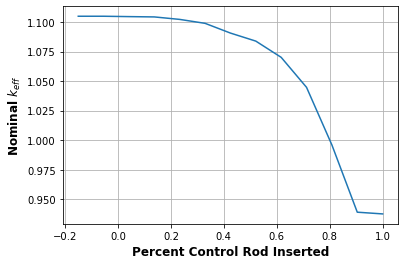

In [31]:
pyplot.plot(pct_insert_2,k_out_plus_lf[0,:]);
pyplot.grid();
pyplot.xlabel('Percent Control Rod Inserted',fontsize=12,fontweight='bold');
pyplot.ylabel('Nominal $k_{eff}$',fontsize=12,fontweight='bold');


This still doesn't show a reactivity increase as graphite is inserted.  I wonder if it becomes prominent if you model (in some way) the density gradient of the water in the core. (?)